# Data Processing Notebook
This notebook will process data collected by `deep_tube_learning/data_collection.py`, including visualizing some sample data and generating the default dataset for training tube dynamics or error dynamics, $$\mathcal{D} = \{z_t, P_z(x_t), v_t, z_{t+1}, P_z(x_{t+1})\}$$

In [1]:
import os
import glob
import wandb
import pickle
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

First, load in the data. This will grab data from `wandb` if data is not currently downloaded locally (otherwise, it will use the local data).

In [2]:
run_id = "fxqv2jkf"
experiment = f"coleonguard-Georgia Institute of Technology/RoM_Tracking_Data/{run_id}_rom_tracking_data:latest"

# Download data if it isn't held locally
if not os.path.exists(run_id):
    api = wandb.Api()
    artifact = api.artifact(experiment)
    data = artifact.download(root=Path(run_id))

# Combine epoch data into a single dataset
epoch_files = glob.glob(f"{run_id}/epoch_*.pickle")
z, v, x, u, done, pz_x, data_shape = None, None, None, None, None, None, None
for epoch_file in epoch_files:
    with open(epoch_file, "rb") as f:
        epoch_data = pickle.load(f)
        
    # Reshape data to remove the 'num_robots' axis
    # Note that by removing N+1 element from z, Pz_x, all arrays now have same leading axis
    # Since the last element of leading axis always has done=True, removing 'num_robots' axis will not lead to spurious transition
    z_e = epoch_data['z'][:-1, :, :]
    data_shape = z_e.shape
    z_e = z_e.reshape((data_shape[0] * data_shape[1], -1), order='F')
    v_e = epoch_data['v'].reshape((data_shape[0] * data_shape[1], -1), order='F')
    x_e = epoch_data['x'][:-1, :, :].reshape((data_shape[0] * data_shape[1], -1), order='F')
    u_e = epoch_data['u'].reshape((data_shape[0] * data_shape[1], -1), order='F')

    done_e = epoch_data['done']
    done_e[-1, :] = True
    done_e = done_e.reshape((data_shape[0] * data_shape[1], -1), order='F')
    pz_x_e = epoch_data['pz_x'][:-1, :, :].reshape((data_shape[0] * data_shape[1], -1), order='F')
        
    # Concatenate with other data
    if z is None:
        z = z_e
        v = v_e
        x = x_e
        u = u_e
        done = done_e
        pz_x = pz_x_e
    else:
        z = np.vstack((z, z_e))
        v = np.vstack((v, v_e))
        x = np.vstack((x, x_e))
        u = np.vstack((u, u_e))
        done = np.vstack((done, done_e))
        pz_x = np.vstack((pz_x, pz_x_e))

# Translate arrays by one for next steps
z_p1 = z
z_p1[:-1, :] = z[1:, :]
pz_x_p1 = pz_x
pz_x_p1[:-1, :] = pz_x[1:, :]

# Remove 'done' transitions
done = np.squeeze(done)
z = z[np.logical_not(done), :]
v = v[np.logical_not(done), :]
pz_x = pz_x[np.logical_not(done), :]
z_p1 = z_p1[np.logical_not(done), :]
pz_x_p1 = pz_x_p1[np.logical_not(done), :]

# Save dataset
dataset = {
    'z': z,
    'pz_x': pz_x,
    'v': v,
    'z_p1': z_p1,
    'pz_x_p1': pz_x_p1,
}

with open(f"{run_id}/dataset.pickle", "wb") as f:
    pickle.dump(dataset, f)

Next, plot some sample data to examine performance of the planning/tracking models

Text(0, 0.5, 'Commanded Velocities')

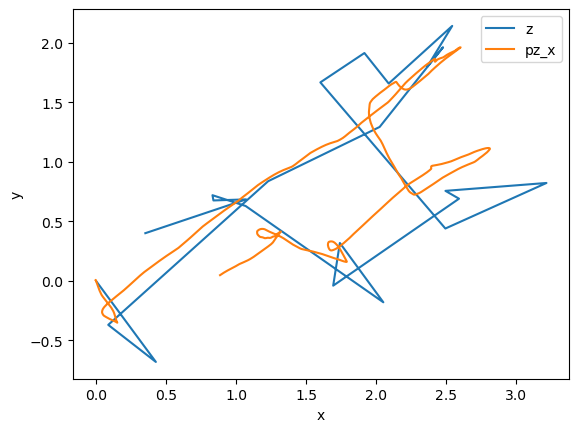

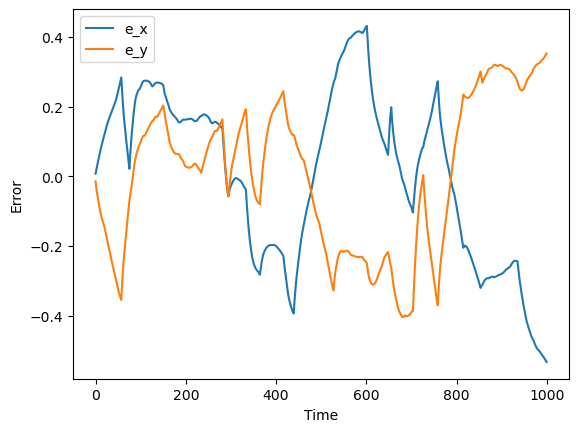

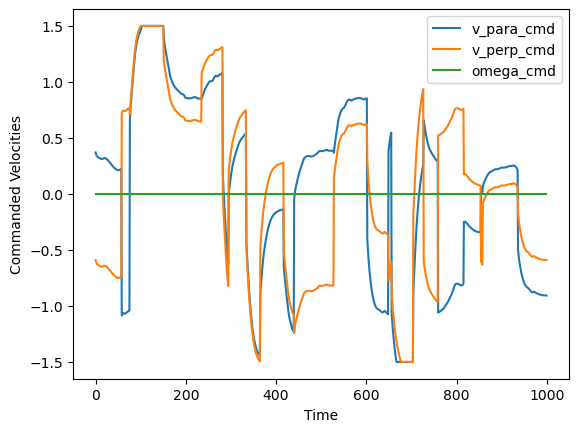

In [3]:
epoch = 0
robot = 0

ind = epoch * data_shape[0] * data_shape[1] + robot * data_shape[1]

z_data = z[ind:ind + data_shape[0] - 1, :]
v_data = v[ind:ind + data_shape[0] - 1, :]
pz_x_data = pz_x[ind:ind + data_shape[0] - 1, :]
u_data = u[ind:ind + data_shape[0] - 1, :]

plt.figure()
plt.plot(z_data[:, 0], z_data[:, 1])
plt.plot(pz_x_data[:, 0], pz_x_data[:, 1])
plt.legend(['z', 'pz_x'])
plt.xlabel('x')
plt.ylabel('y')

plt.figure()
plt.plot(z_data[:, 0] - pz_x_data[:, 0])
plt.plot(z_data[:, 1] - pz_x_data[:, 1])
plt.legend(['e_x', 'e_y'])
plt.xlabel('Time')
plt.ylabel('Error')

plt.figure()
plt.plot(u_data)
plt.legend(['v_para_cmd', 'v_perp_cmd', 'omega_cmd'])
plt.xlabel('Time')
plt.ylabel('Commanded Velocities')